In [10]:
%matplotlib inline
import fc_densenet_torch
import torch
from skimage.morphology import binary_dilation,disk
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time
from importlib import  reload
import run_dense_lumen
import numpy as np
from matplotlib.pyplot import imshow
from glob import glob
import tifffile as tiff
import pandas as pd
from skimage.exposure import equalize_adapthist, equalize_hist
from skimage import img_as_float
import copy
from tqdm import tqdm_notebook
import run_dense_lumen
from PIL import Image

In [13]:
net = fc_densenet_torch.fcdensenet56().cuda()
net.load_state_dict(torch.load('../FC-DenseNet/models/56_e1000.pth'))

In [15]:
# helper plotting function
def plot_lumen(test1, ax):
    a1 = test1['image'].numpy()[0,0]
   
    output_test = net(Variable(test1['image']).cuda(0))
    _, predicted = torch.max(output_test.data, 1)
    predicted = torch.squeeze(predicted.cpu()).numpy()
    predicted_outline = np.logical_xor(predicted, binary_dilation(predicted))
#     toplot_predicted = np.ma.masked_where(predicted_outline, a1)

    toplot_predicted = a1.copy()
    toplot_predicted -= toplot_predicted.min()
    toplot_predicted /= toplot_predicted.max()
    toplot_predicted = equalize_adapthist(toplot_predicted, clip_limit=0.1)
#     toplot_predicted[predicted_outline] = np.NaN
    
    palette = copy.copy(plt.cm.gray)
    palette.set_bad('r', 1.0)
#     ax.imshow(toplot_predicted, cmap=palette);
    
    only_seg = np.ma.masked_where(predicted==0,predicted)
    ax.imshow(only_seg, cmap='jet_r')
    return toplot_predicted
#     ax.axis('off')

In [48]:
trainloader = run_dense_lumen.LumenDataset('/home/jakob/Code/nn/lumen/data/ground_truth_seg/val', transform=None)

found 48 files


/home/jakob/Code/nn/neural_seg/fc_densenet_torch.py:143: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.logsoftmax(x)


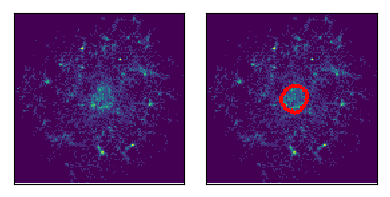

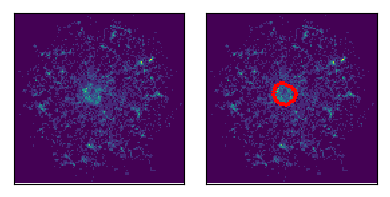

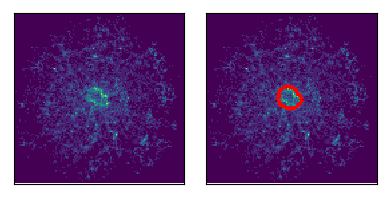

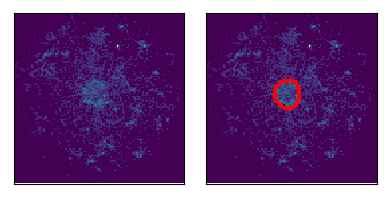

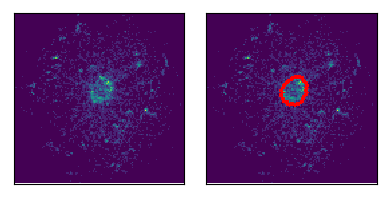

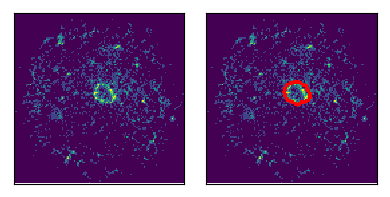

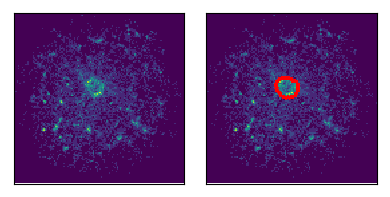

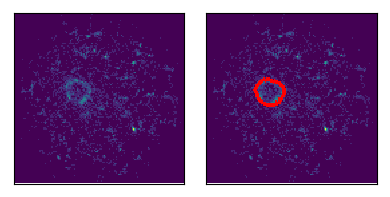

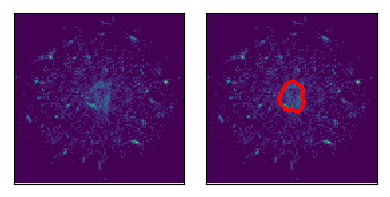

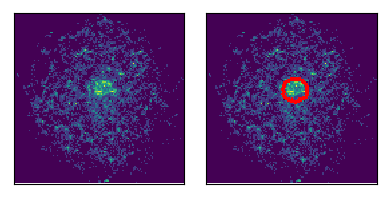

In [50]:
for i1 in range(10):
    test1 = trainloader[i1]
    a1, a2 = test1['image'].numpy()[0], test1['image_labeled'].numpy()
    
    a1 -= a1.min()
    a1 /= a1.max()
#     a1 = equalize_adapthist(a1,clip_limit=0.03)
    
    output_test = net(Variable(test1['image'].unsqueeze(0)).cuda(0))
    _, predicted = torch.max(output_test.data, 1)
    predicted = torch.squeeze(predicted).cpu().numpy()

    predicted_outline = np.logical_xor(predicted, binary_dilation(predicted, selem=disk(3)))
    toplot_predicted = np.ma.masked_where(predicted_outline, a1)
    
    toplot = a1.copy()
    toplot[predicted_outline] = np.NaN
    palette = copy.copy(plt.cm.viridis)
    palette.set_bad('r', 1.0)
    
    fig,ax=plt.subplots(1,2, figsize=(4,4))

    a3 = np.ma.masked_where(a2==0,a2)
#     ax[1].imshow(toplot, cmap='jet_r')
    ax[1].imshow(toplot, cmap=palette)
    ax[0].imshow(a1, cmap=palette);
    # [axi.axis('off') for axi in ax];
    [axi.yaxis.set_visible(False) for axi in ax];
    [axi.xaxis.set_visible(False) for axi in ax];
    fig.tight_layout()
#     fig.savefig('pics/im{:n}.png'.format(i1), bbox_inches='tight', transparent=True, pad_inches=0)